# Analysis of the coding mutations

Created: **17/07/18**  
Last modified: **02/08/18**

**Goal:** further analysis on the cleaned dataset `cleaned_IMPACT_mutations_180508.txt`, enriched with the annotations from the `add_features()` function obtained at the end of `annotate_cleaned_dataset.ipynb`. The `synonymous_SNV` are excluded from this study, which only focus on the coding mutations.  
This notebook is divided in two (independant) parts:
* **1. The `class` feature: somatic vs non-somatic**: introduce a new feature to class the coding mutations as somatic or non-somatic, and compare these two classes (frequency_in_normals, vaf, strand bias, Kaviar_AF, cosmic count).  
* **2. The `mut_key` feature: study of shared mutations**: study the reccurence of coding mutations and the possible inconsistent labels.

**Refs:**
* [CodingDistributions.Rmd [Elsa]](
https://github.com/ElsaB/impact-annotator/blob/master/analysis/description/180510_elsa/CodingDistributions.Rmd)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-class-feature:-somatic-vs-non-somatic" data-toc-modified-id="The-class-feature:-somatic-vs-non-somatic-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>class</code> feature: somatic vs non-somatic</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals" data-toc-modified-id="Comparison-of-the-frequency_in_normals-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code></a></span></li><li><span><a href="#Comparison-of-the-t_vaf" data-toc-modified-id="Comparison-of-the-t_vaf-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of the <code>t_vaf</code></a></span></li><li><span><a href="#Comparison-of-the-strand-bias" data-toc-modified-id="Comparison-of-the-strand-bias-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of the strand bias</a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-key-feature:-study-of-shared-mutations" data-toc-modified-id="The-key-feature:-study-of-shared-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>key</code> feature: study of shared mutations</a></span><ul class="toc-item"><li><span><a href="#Studying-the-reccurence-of-mutations" data-toc-modified-id="Studying-the-reccurence-of-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Studying the reccurence of mutations</a></span></li><li><span><a href="#Study-of-the-proportion-of-inconsistent-features" data-toc-modified-id="Study-of-the-proportion-of-inconsistent-features-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Study of the proportion of inconsistent features</a></span></li><li><span><a href="#Sudy-of-the-reccurent-mutations" data-toc-modified-id="Sudy-of-the-reccurent-mutations-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Sudy of the reccurent mutations</a></span></li></ul></li></ul></div>

***

In [3]:
source("../../../src/utils/custom_tools.R")
setup_environment()

In [4]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

The `synonymous_SNV` are excluded from this study, which focus only on the coding mutations. Anyway most of them were classified as `UNKNOWN`.

In [5]:
impact <- impact[impact$Consequence != "synonymous_SNV",] # remove the synonymous mutations
nrow(impact)

[1] 198340

## The `class` feature: somatic vs non-somatic

### Creating the feature

We remove the mutations curated as `UNKNOWN` and create a new feature `class`:
* A mutation has `class = somatic` if `confidence_class = AUTO_OK | MANUAL_OK`
* A mutation has `class = non-somatic` if `confidence_class = UNLIKELY | OK_NOT_SO` (it is either a germline or an artefact)

In [11]:
impact <- impact[impact$confidence_class != "UNKNOWN",] # keep only the curated mutation
impact$class <- "non-somatic"
impact$class[impact$confidence_class == "AUTO_OK" | impact$confidence_class == "MANUAL_OK"] <- "somatic"
addmargins(table(impact$class, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$class == "non-somatic",]) / nrow(impact) # percentage of non-somatic mutations

,AUTO_OK,MANUAL_OK,OK_NOT_SO,UNLIKELY,Sum
non-somatic,0,0,345,10868,11213
somatic,180763,6335,0,0,187098


[1] 5.65425

The dataset is highly unbalanced with 11,213 non-somatic mutations ($5.7\%$ of the samples) vs 187,098 somatic mutations ($94.3\%$ of the samples).

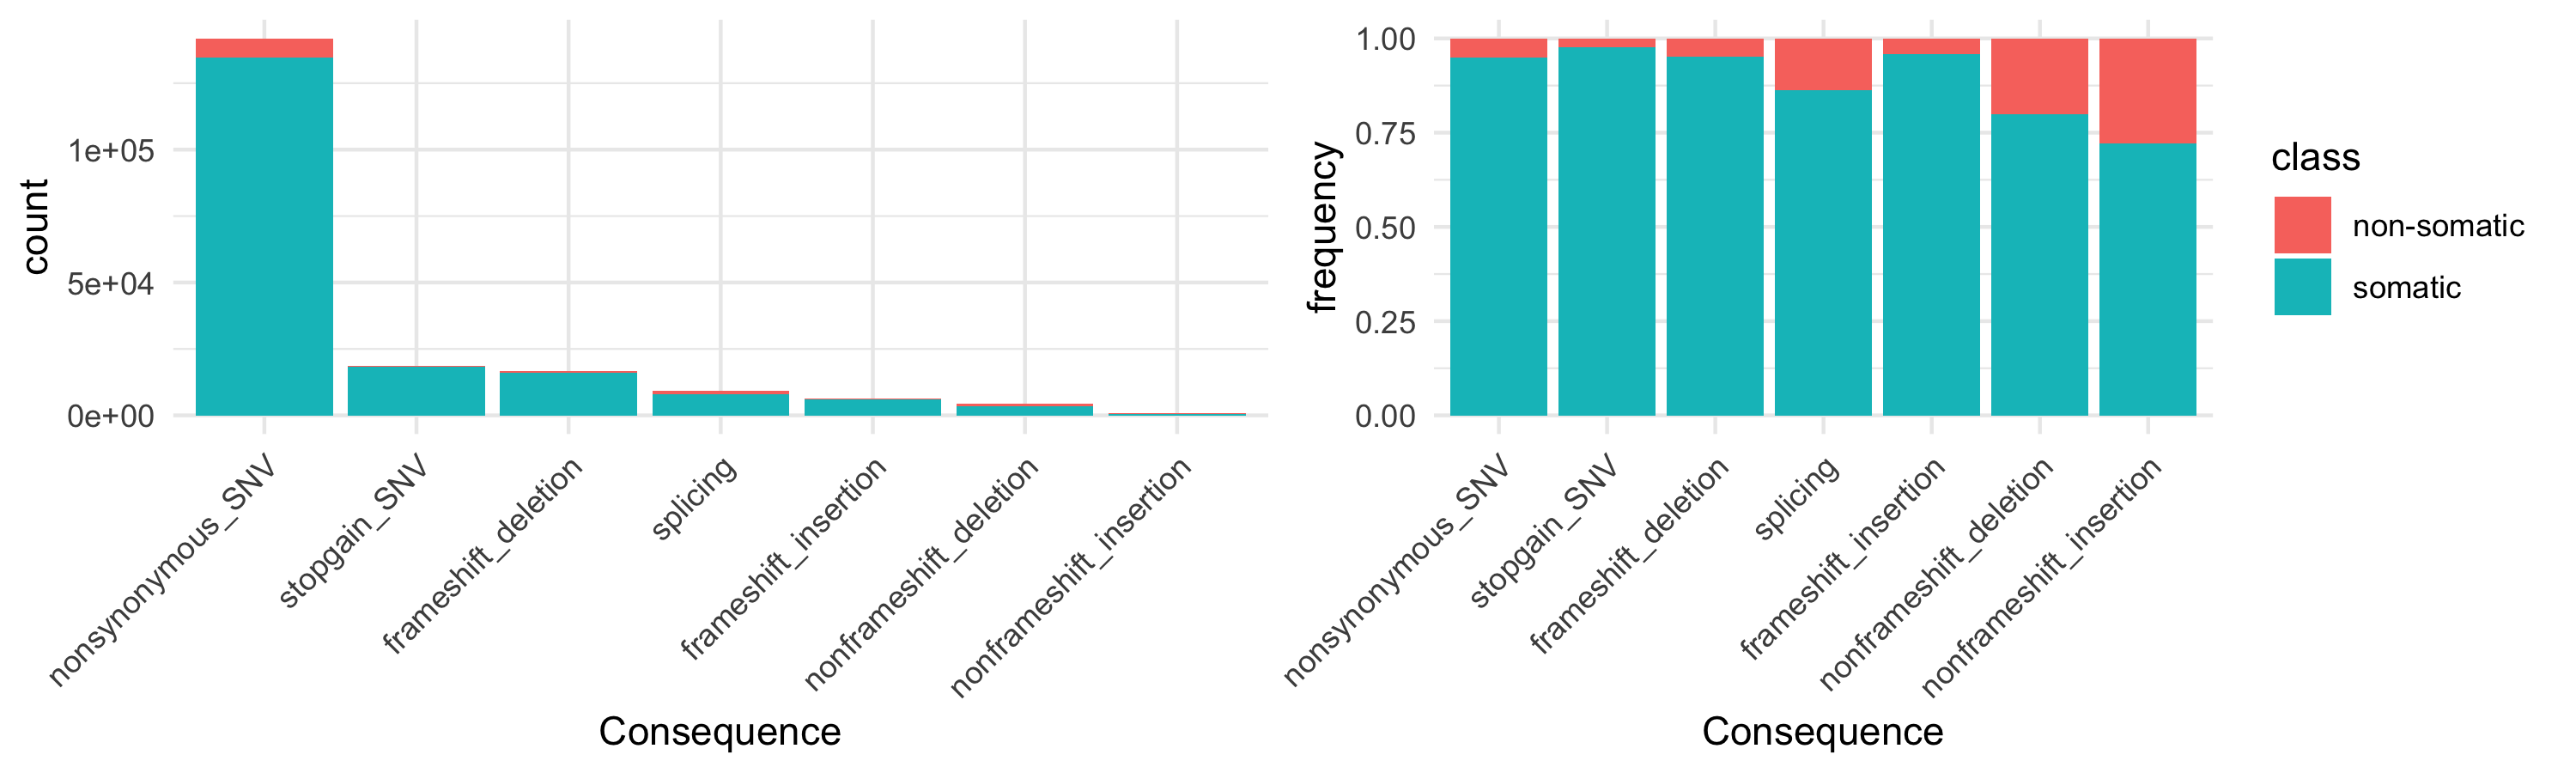

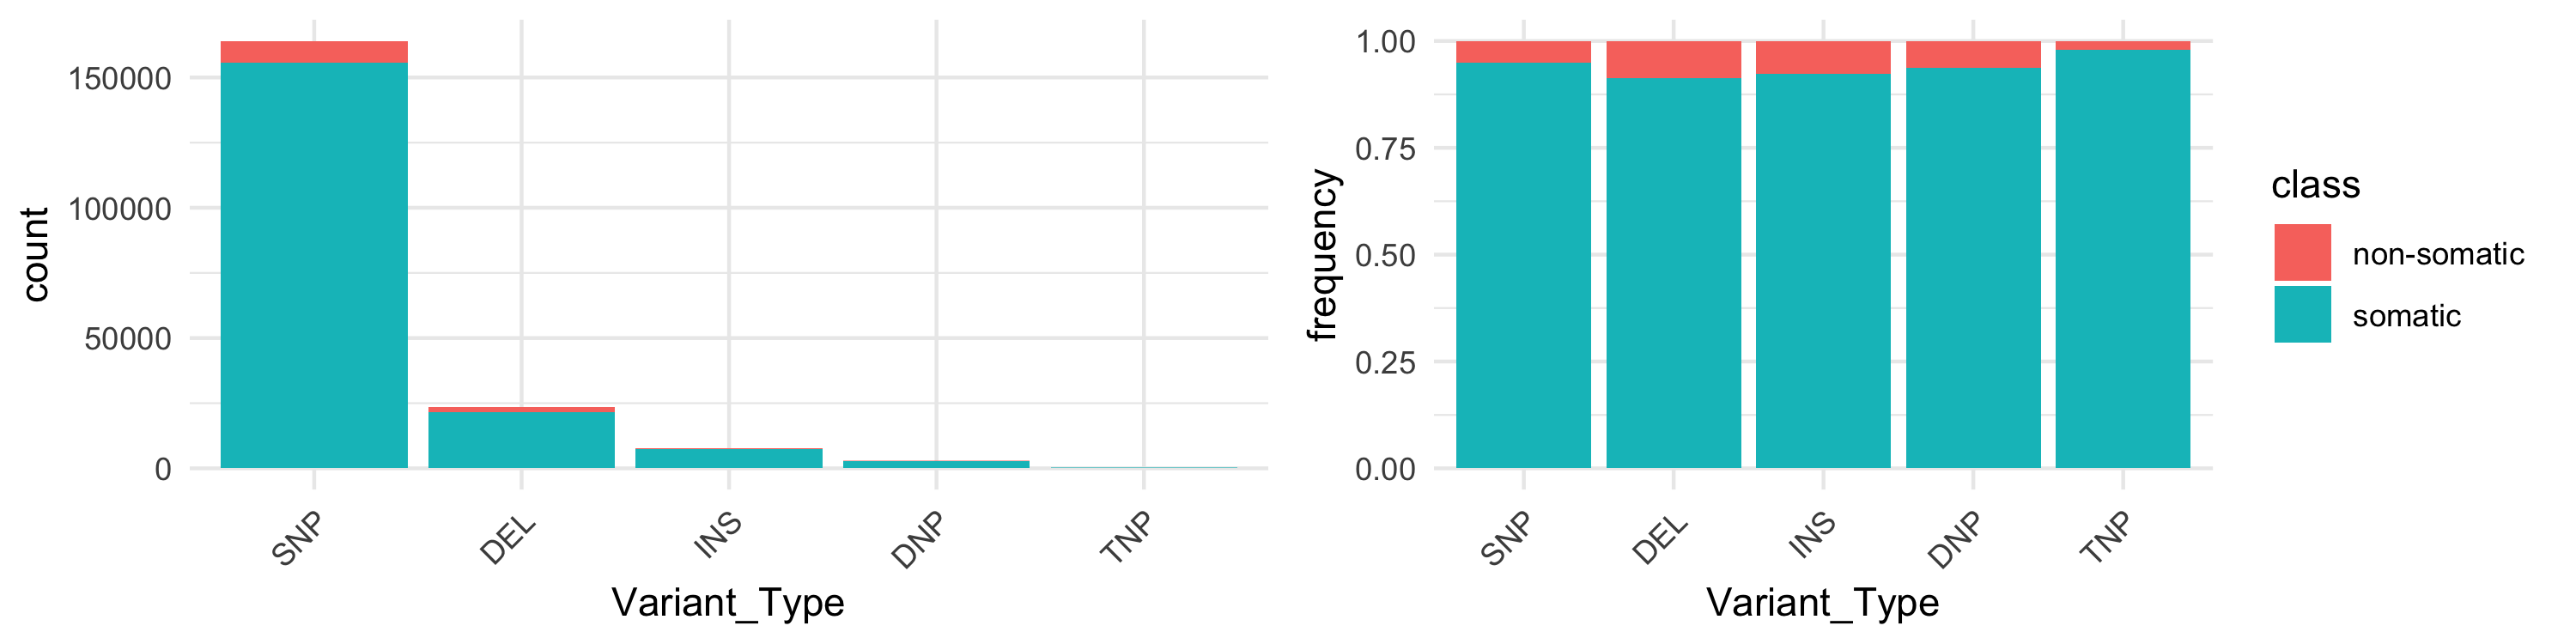

In [12]:
plot_contingency_table_as_histograms(impact, "Consequence", "class")
plot_contingency_table_as_histograms(impact, "Variant_Type", "class", 10, 2.5)

Nothing particularly interesting was found here, it does not seem the mutation `Consequence` or `Variant_Type` features have a clear impact on the `class` of the mutation. We can notice the relatively high amount of `non-somatic` in the `nonframeshift_deletion` and `nonframeshift_insertion` mutations.

### Comparison of the `frequency_in_normals`

Distribution of `frequency_in_normals` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

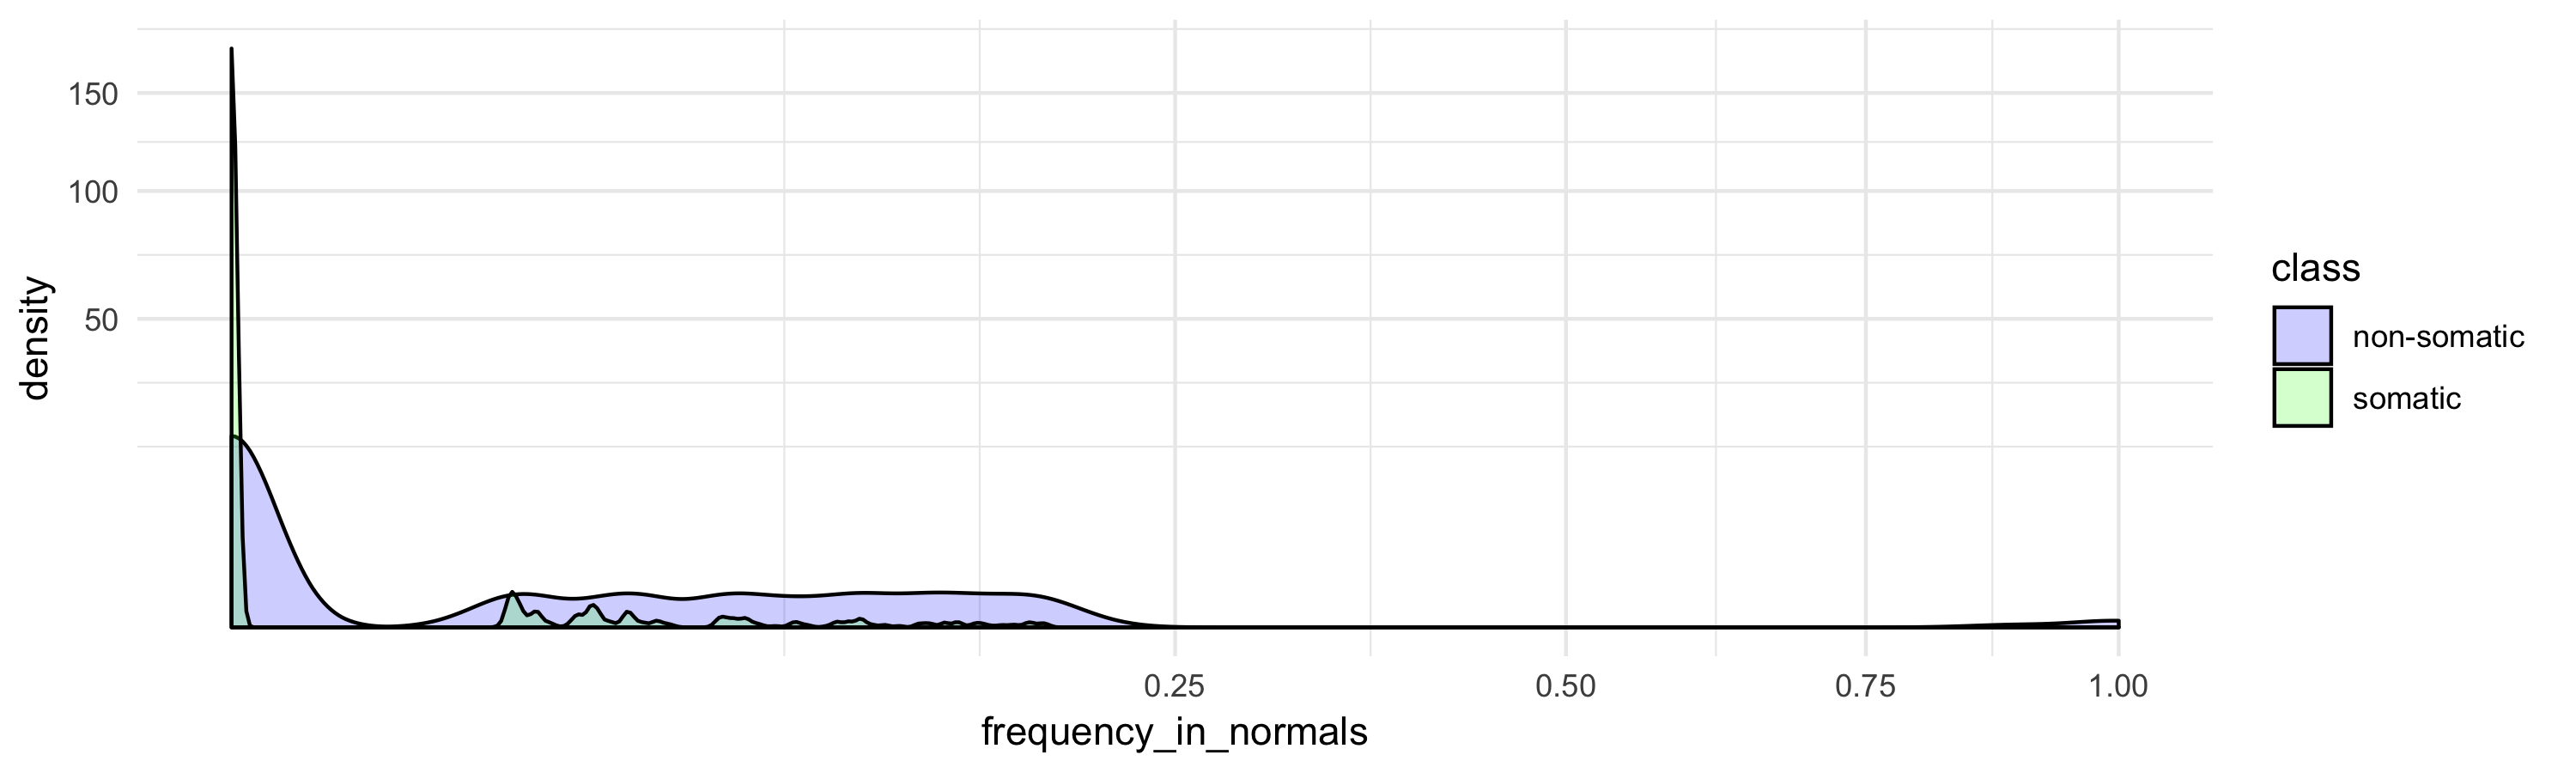

In [13]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(frequency_in_normals, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt()

Overall the non-somatic mutations are, as expected, more present in normals (due to the germline part). However there are some somatic mutations with a not-so-close-to-0 `frequency_in_normals`:

[1] 2052

[1] 174

[1] 0

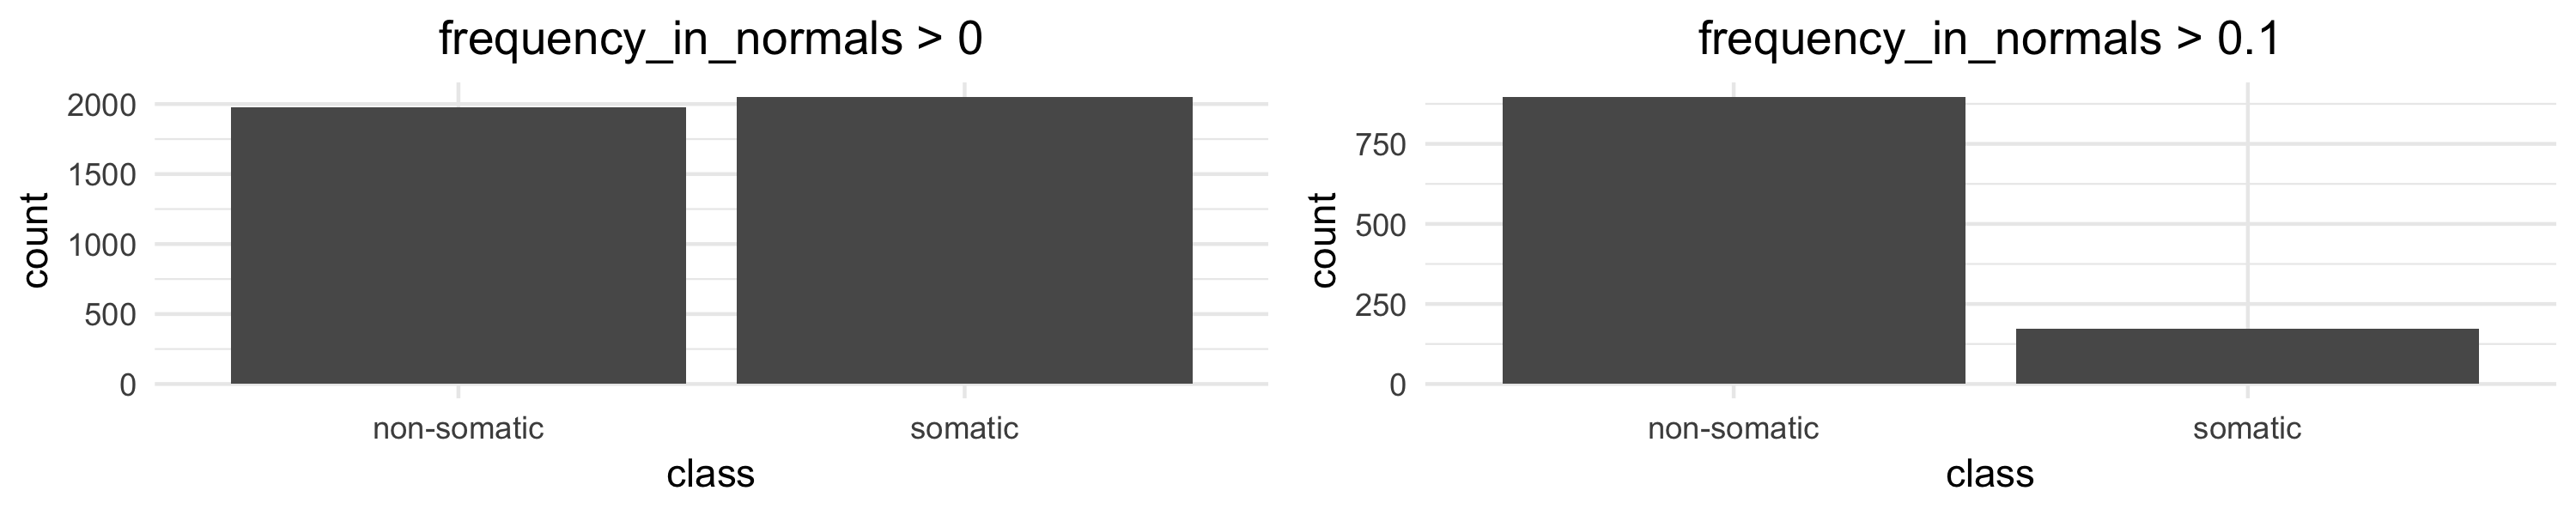

In [20]:
nrow(impact[impact$frequency_in_normals > 0   & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])
nrow(impact[impact$frequency_in_normals > 0.2 & impact$class == "somatic",])

notebook_plot_size(6, 2)
plot1 <- ggplot(impact[impact$frequency_in_normals > 0  ,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0"  ) + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$frequency_in_normals > 0.1,]) + geom_bar(aes(class)) + ggtitle("frequency_in_normals > 0.1") + theme(plot.title = element_text(hjust = 0.5))
plot_side_by_side(plot1, plot2)

[1] "Number of different genes:  73"


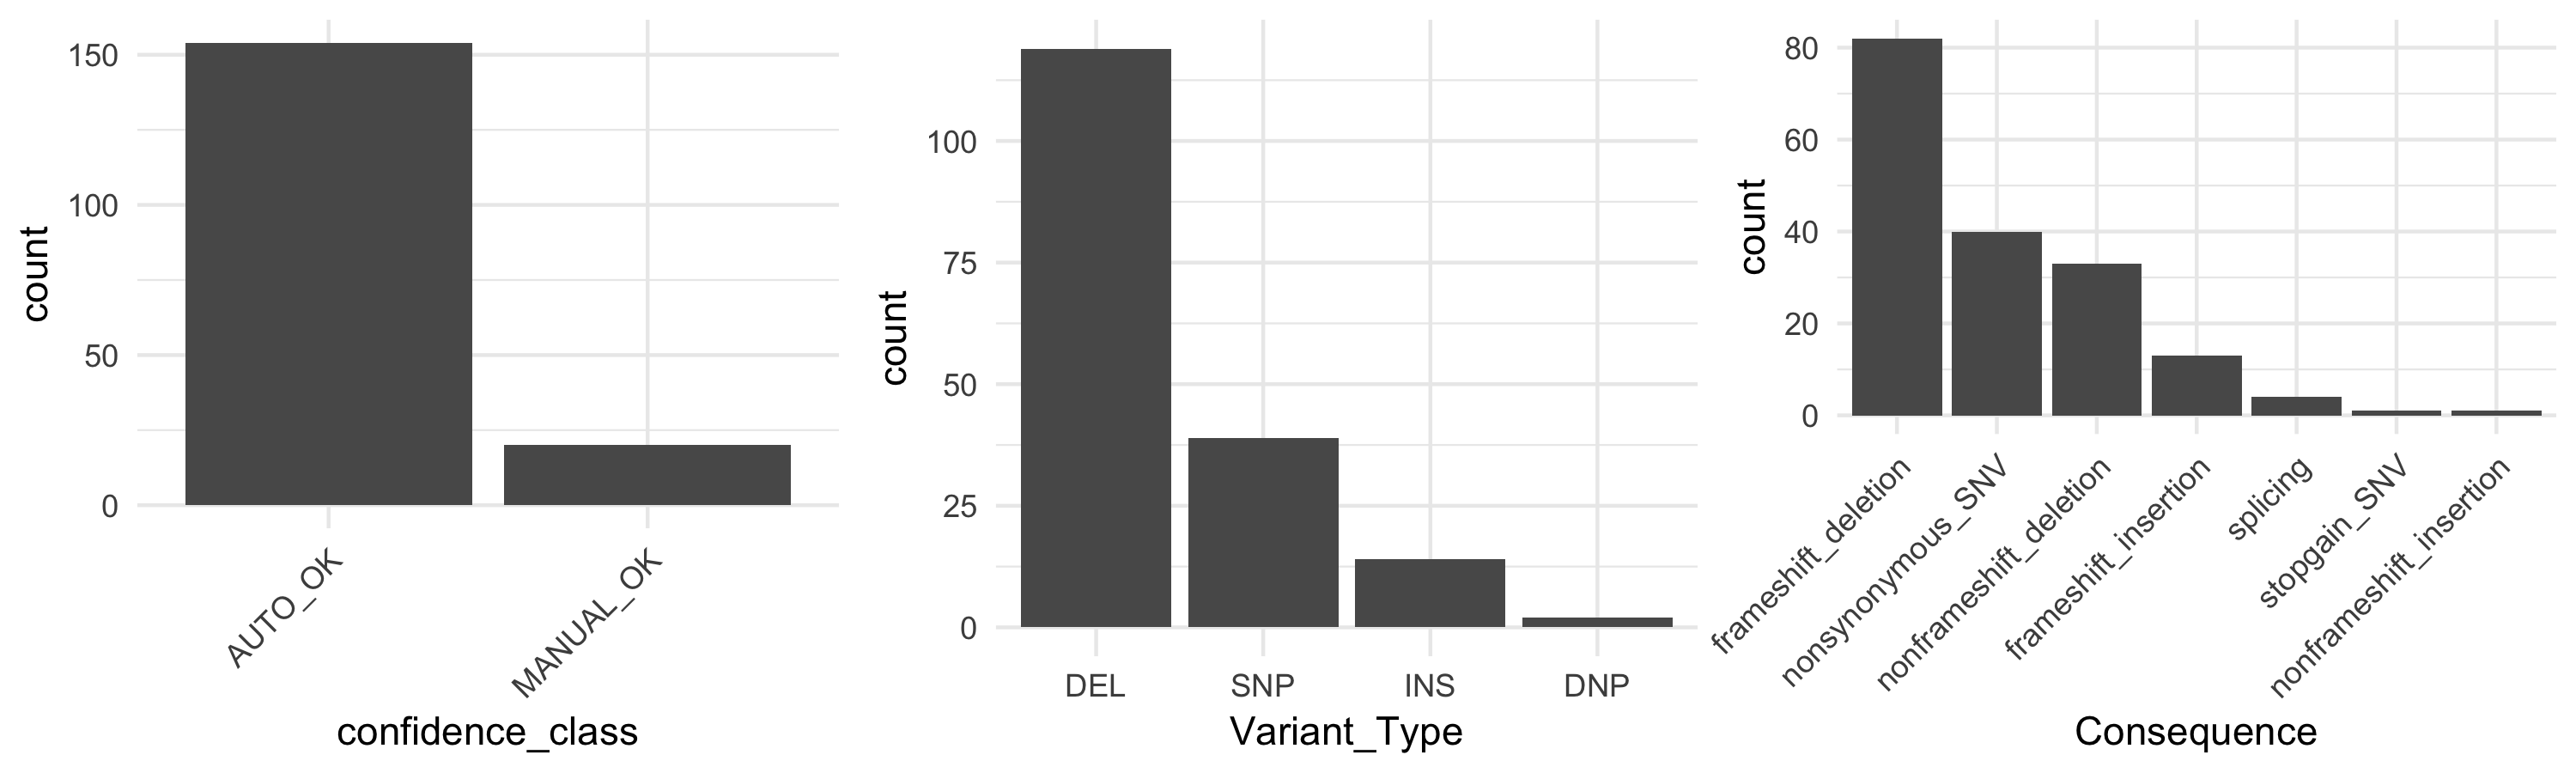

In [21]:
get_possible_correlations(impact[impact$frequency_in_normals > 0.1 & impact$class == "somatic",])

[1] "Number of different genes:  379"


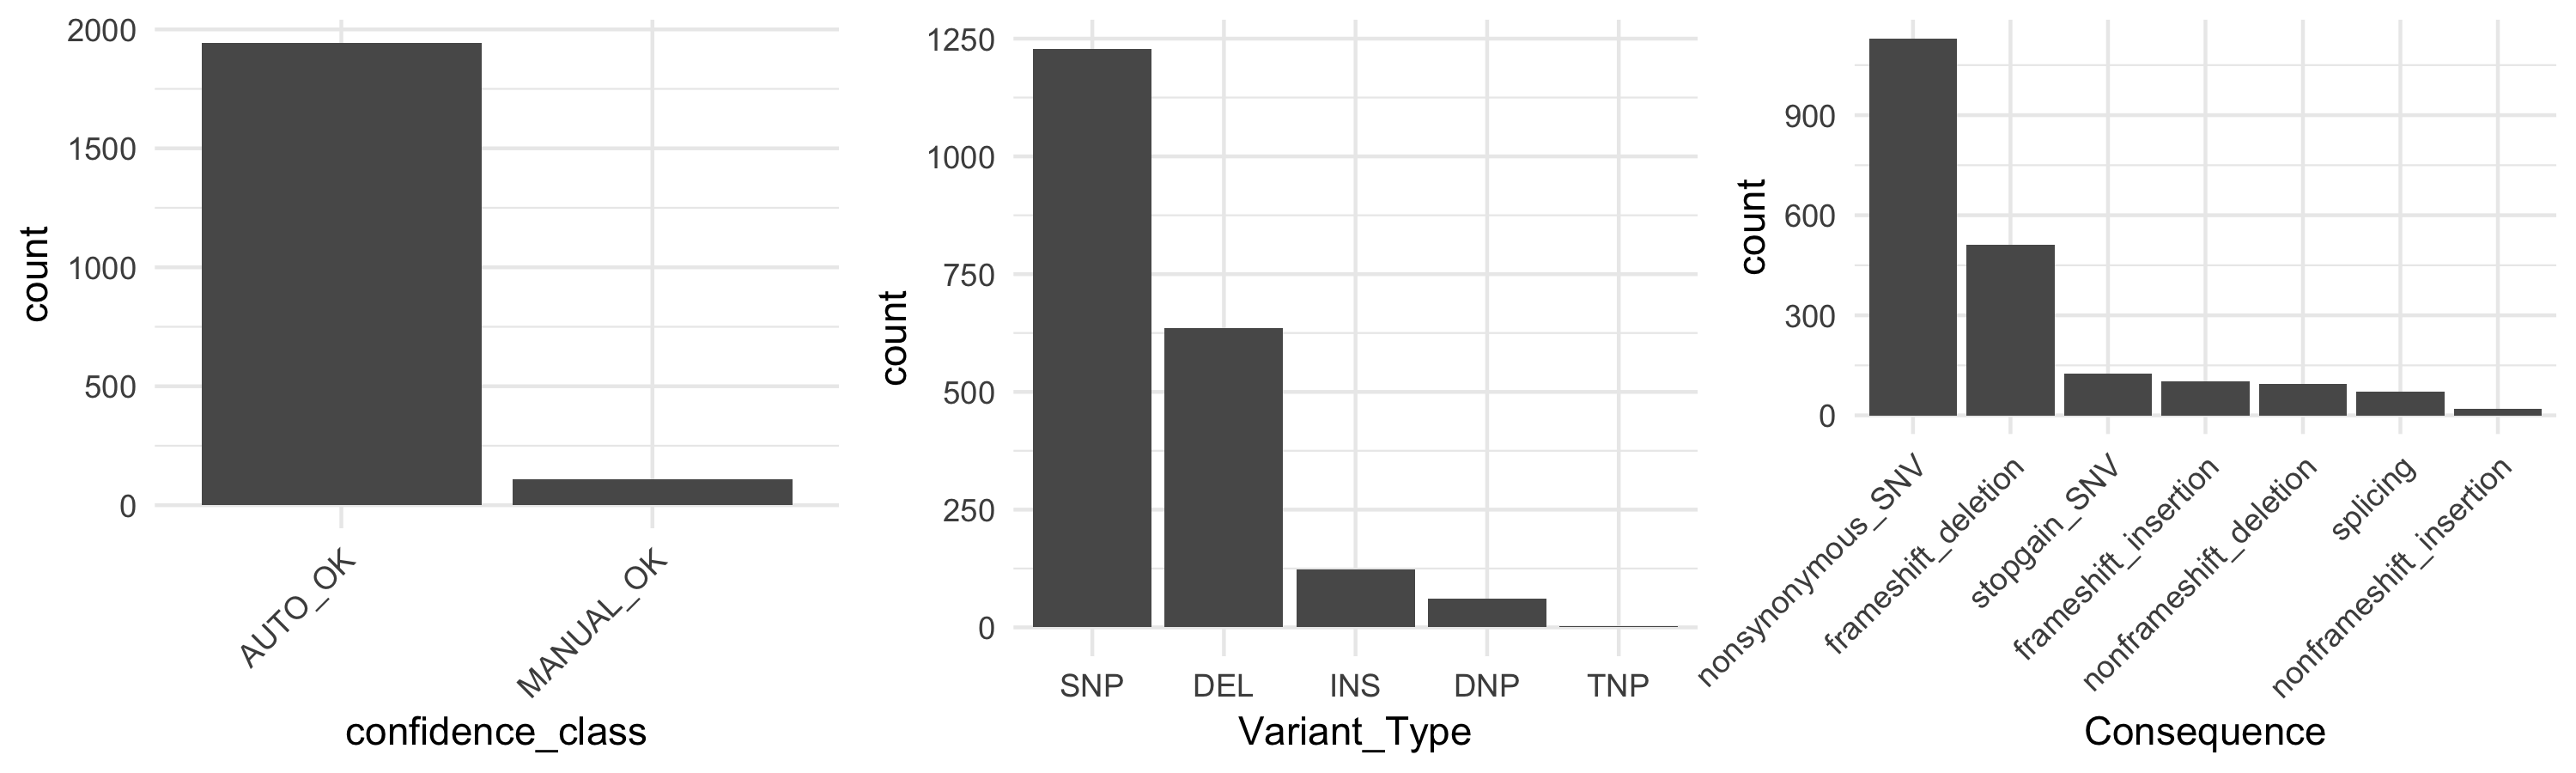

In [22]:
get_possible_correlations(impact[impact$frequency_in_normals > 0 & impact$class == "somatic",])

### Comparison of the `t_vaf`

Distribution of `t_vaf` for the somatic vs non-somatic `class`:

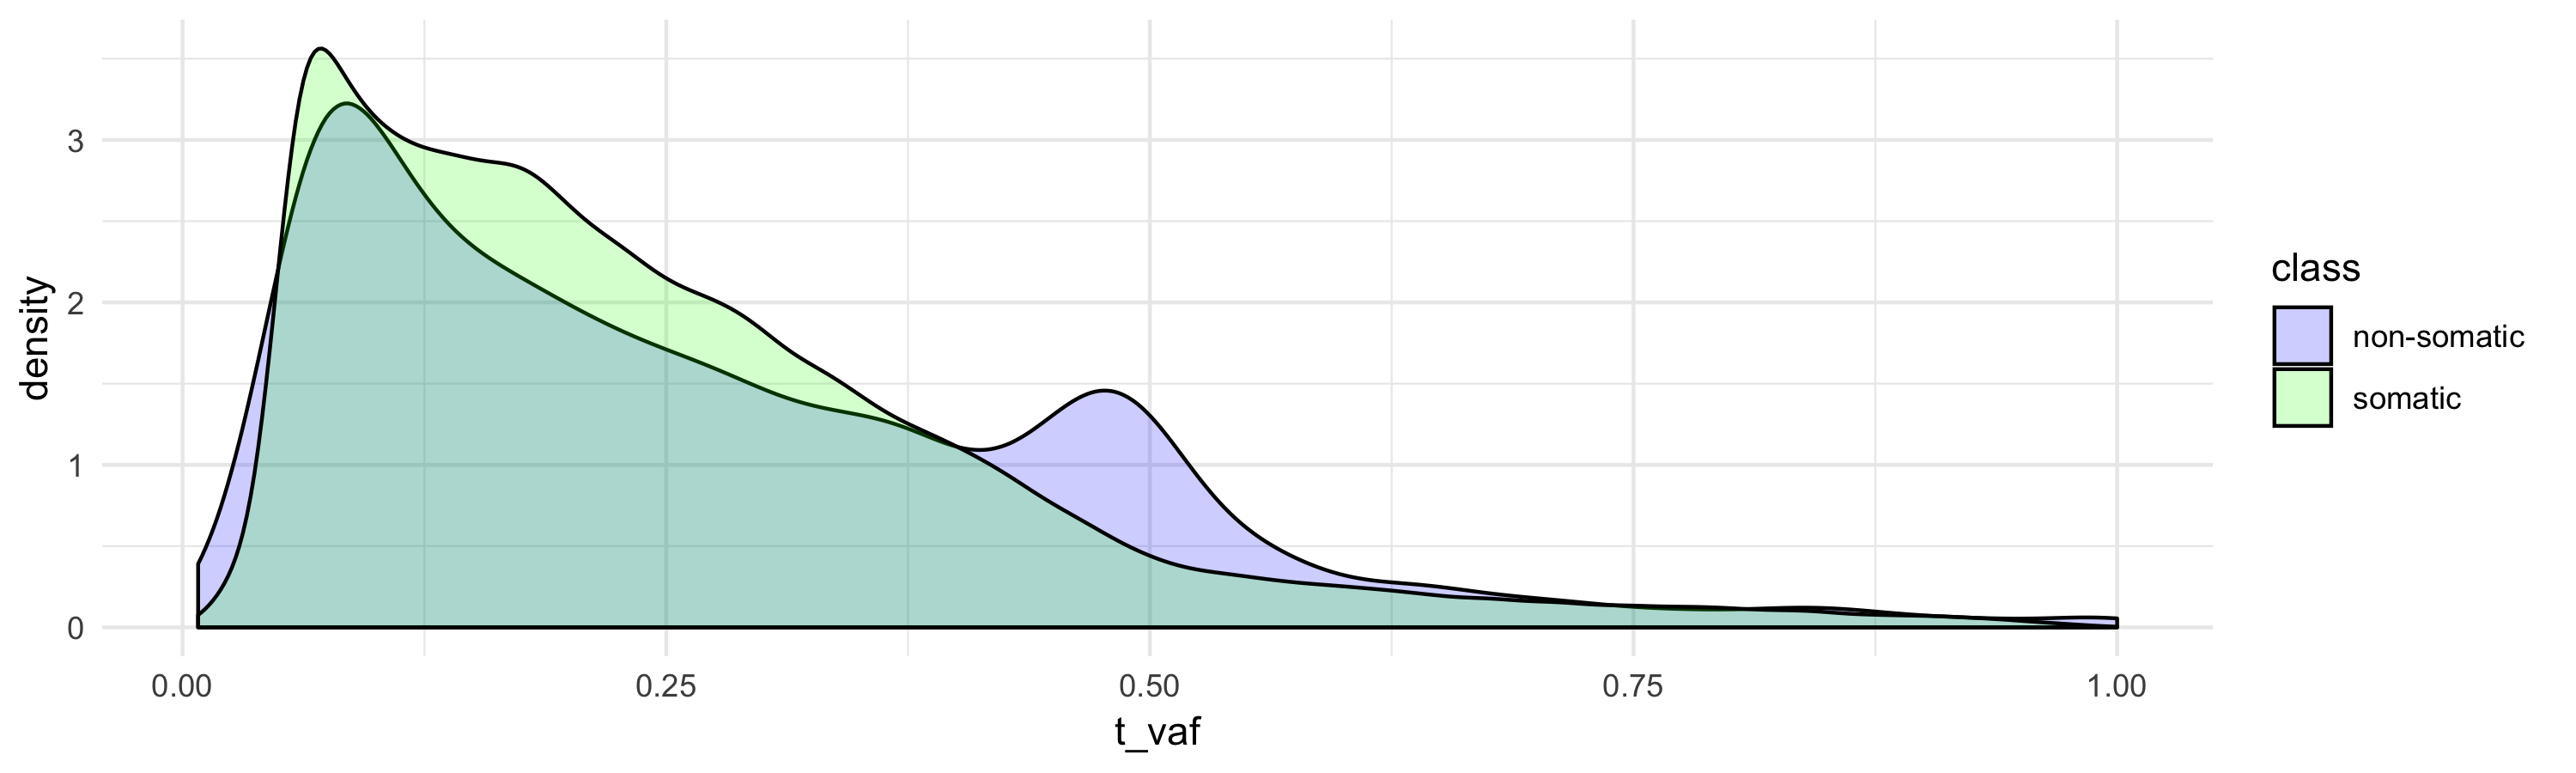

In [23]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(t_vaf, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green"))

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a peak at 0.5 (ie the likely germline calls), and a peak at low VAF (ie the likely artefacts calls)."

### Comparison of the strand bias

We evaluate the `strand_bias` for each mutation as:
$$\text{strand_bias}\ =\ \frac{\min(\text{t_alt_neg_count}, \text{t_alt_plus_count})}
                              {\max(\text{t_alt_neg_count}, \text{t_alt_plus_count})}$$
                              
e.g. the lowest count over the maximum count, thus giving a result between 0 and 1 (1 being a low `strand_bias`, because the count for the neg and pos are the same).

In [24]:
impact$strand_bias <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                      pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `strand_bias` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

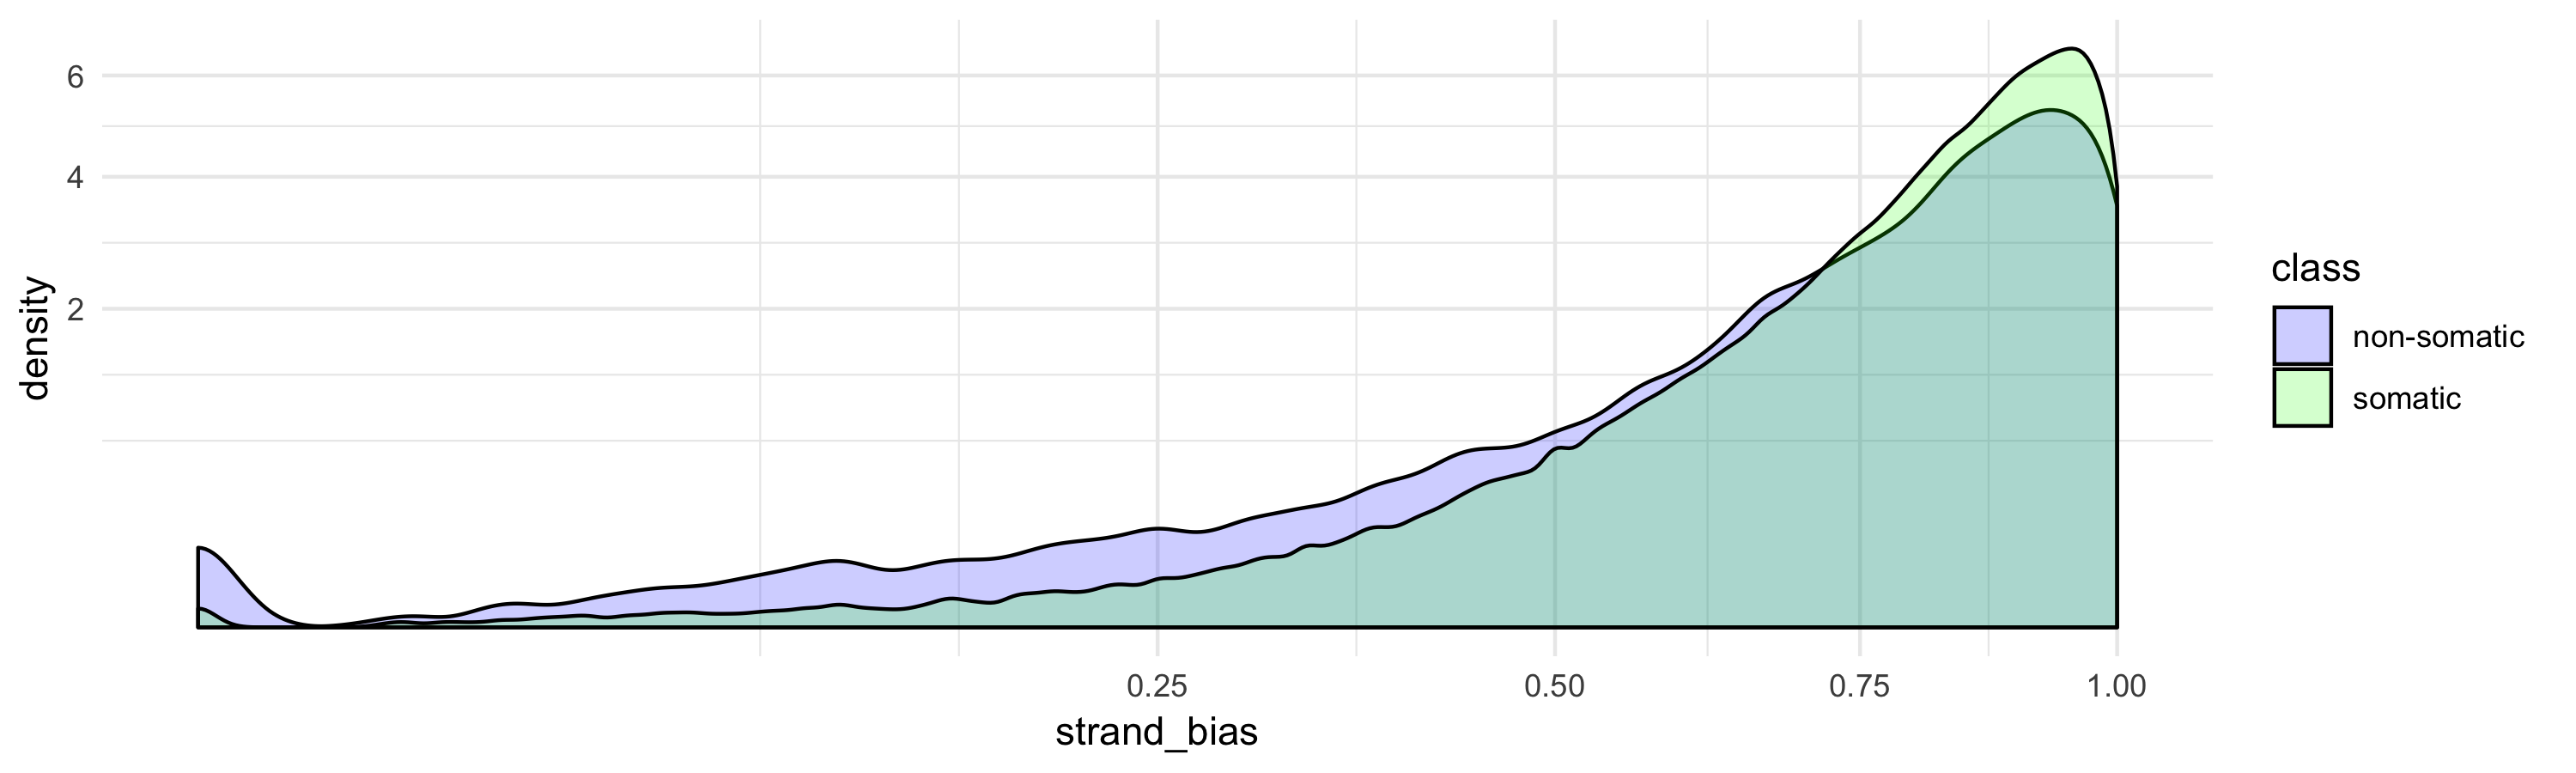

In [25]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(strand_bias, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt()

From `CodingDistributions.Rmd [Elsa]`: "As expected, the non-somatic density has a heavier low strand ratio tail (likely from the artefact calls), although this is not very pronounced."

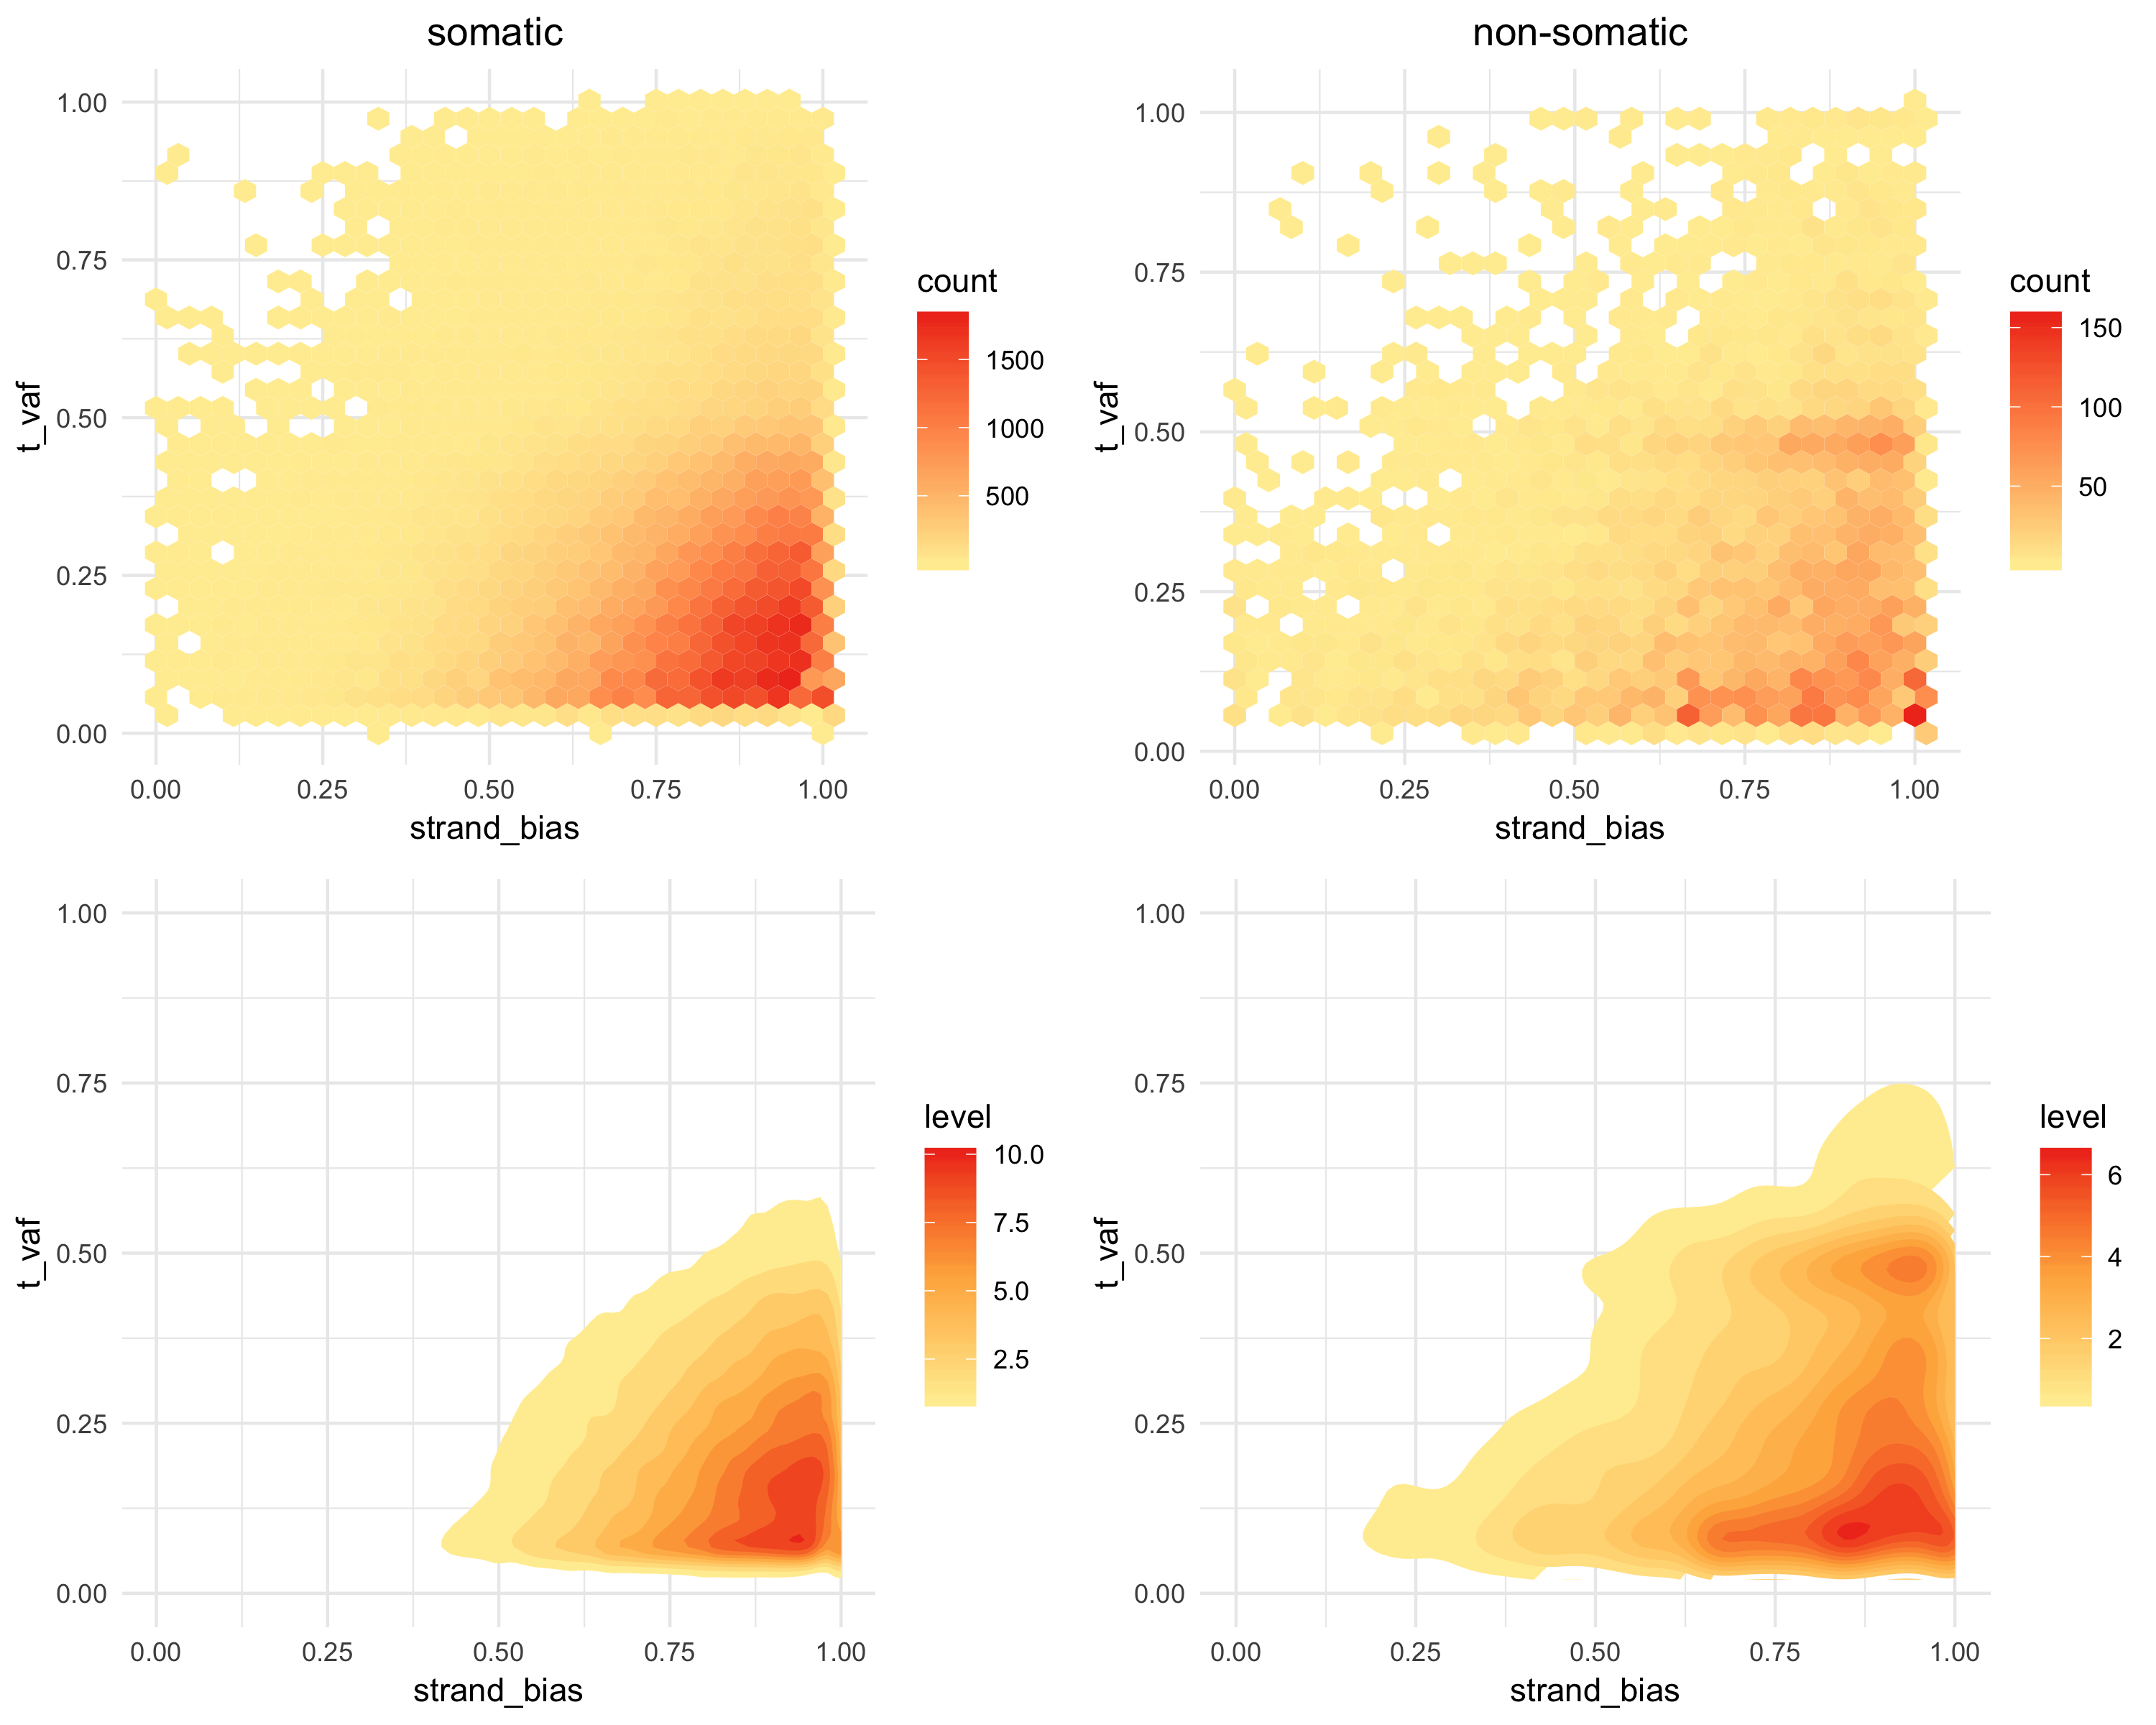

In [26]:
notebook_plot_size(10, 8)
plot1 <- ggplot(impact[impact$class == "somatic",]) + geom_hex(aes(strand_bias, t_vaf)) +
         scale_fill_gradient(low = "#FFEDA0", high = "#F03B20") +
         ggtitle("somatic") + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$class == "non-somatic",]) + geom_hex(aes(strand_bias, t_vaf)) +
         scale_fill_gradient(low = "#FFEDA0", high = "#F03B20") +
         ggtitle("non-somatic") + theme(plot.title = element_text(hjust = 0.5))
plot3 <- ggplot(impact[impact$class == "somatic",]) +
         stat_density_2d(aes(strand_bias, t_vaf, fill = ..level..), geom = "polygon") +
         scale_fill_gradientn(colors = c("#FFEDA0", "#FEB24C", "#F03B20")) +
         coord_cartesian(xlim = c(0, 1), ylim = c(0, 1))
plot4 <- ggplot(impact[impact$class == "non-somatic",]) +
         stat_density_2d(aes(strand_bias, t_vaf, fill = ..level..), geom = "polygon") +
         scale_fill_gradientn(colors = c("#FFEDA0", "#FEB24C", "#F03B20")) +
         coord_cartesian(xlim = c(0, 1), ylim = c(0, 1))

plot_grid(plot1, plot2, plot3, plot4, ncol = 2, nrow = 2)

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

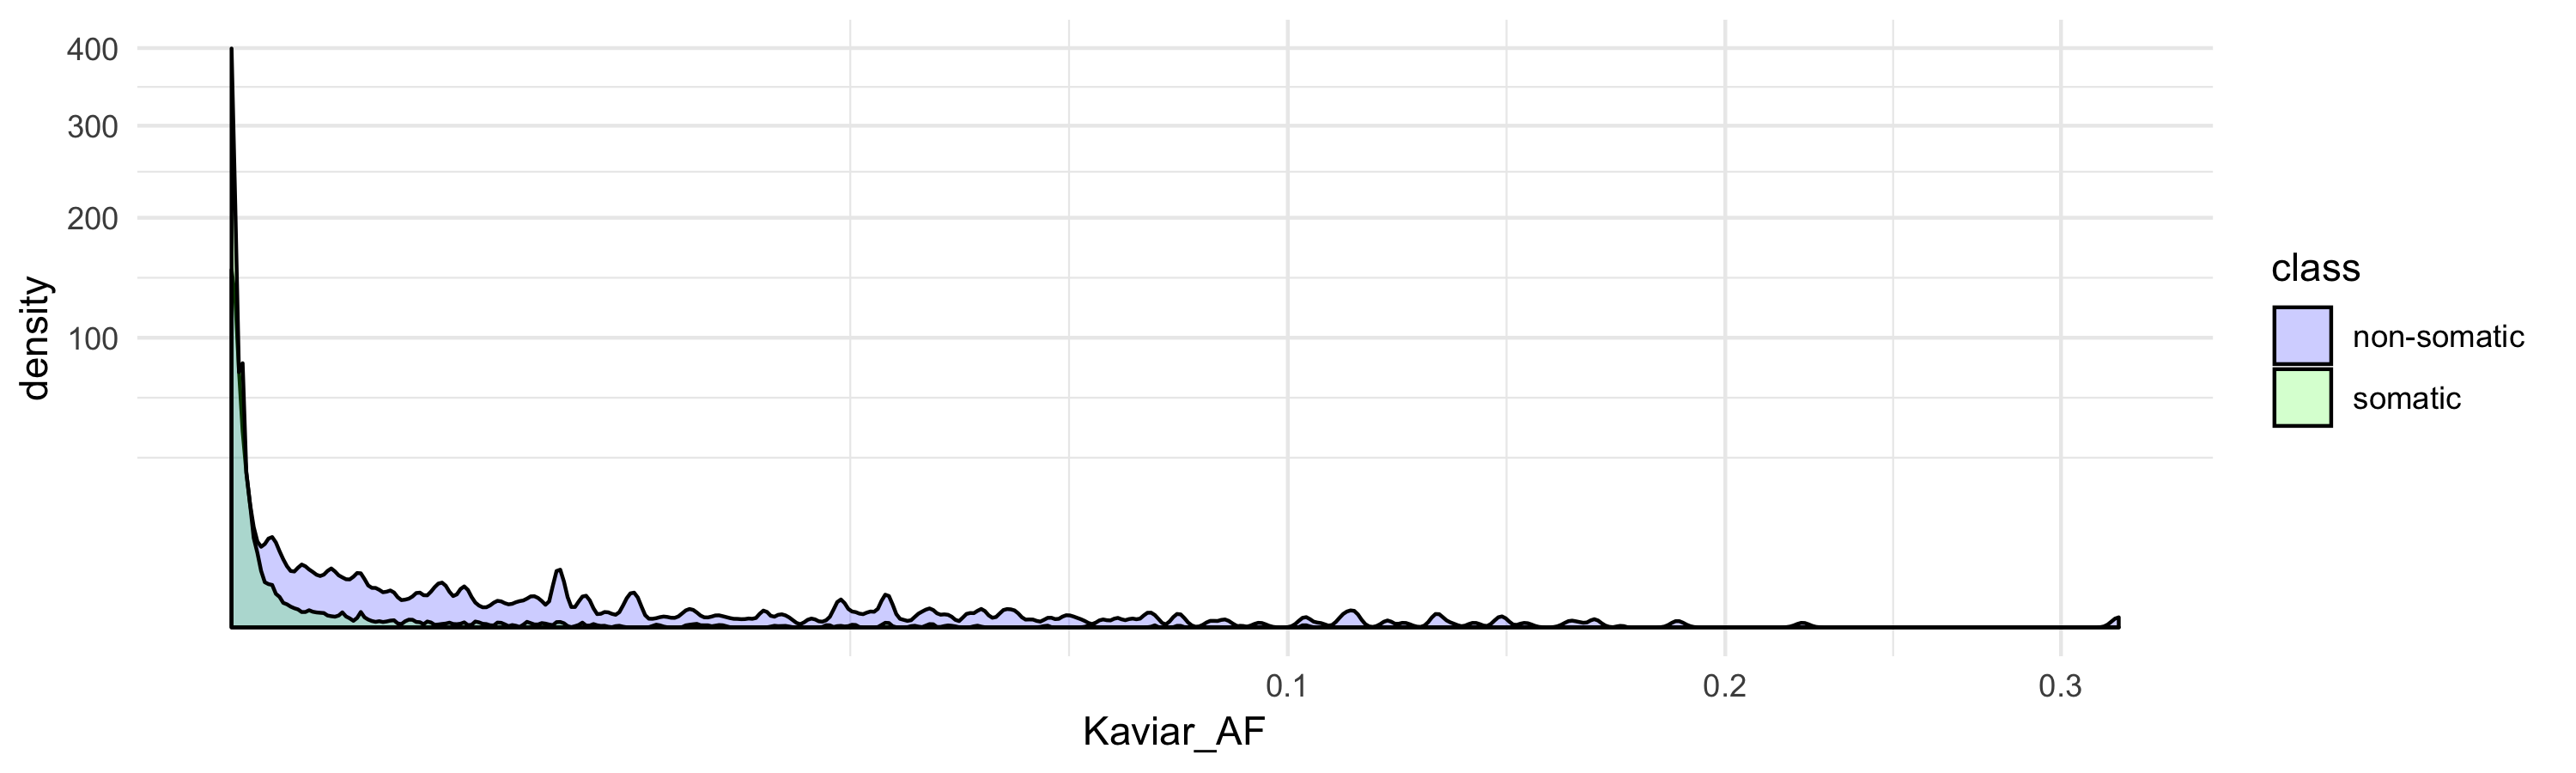

In [27]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(Kaviar_AF, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt() 

What was expected appears clearly, the `non-somatic` class presents a way longer tail on the higher `Kaviar_AF` value (due to the germline calls).

In [29]:
summary(impact$Kaviar_AF[impact$class == "somatic"])
summary(impact$Kaviar_AF[impact$class == "non-somatic"])

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.000026 0.000000 0.172999 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0028339 0.0001423 0.3192330 

### Comparison of `cosmic_count`

Distribution of `cosmic_count` for the somatic vs non-somatic `class` (warning this is a sqrt x and sqrt y scale):

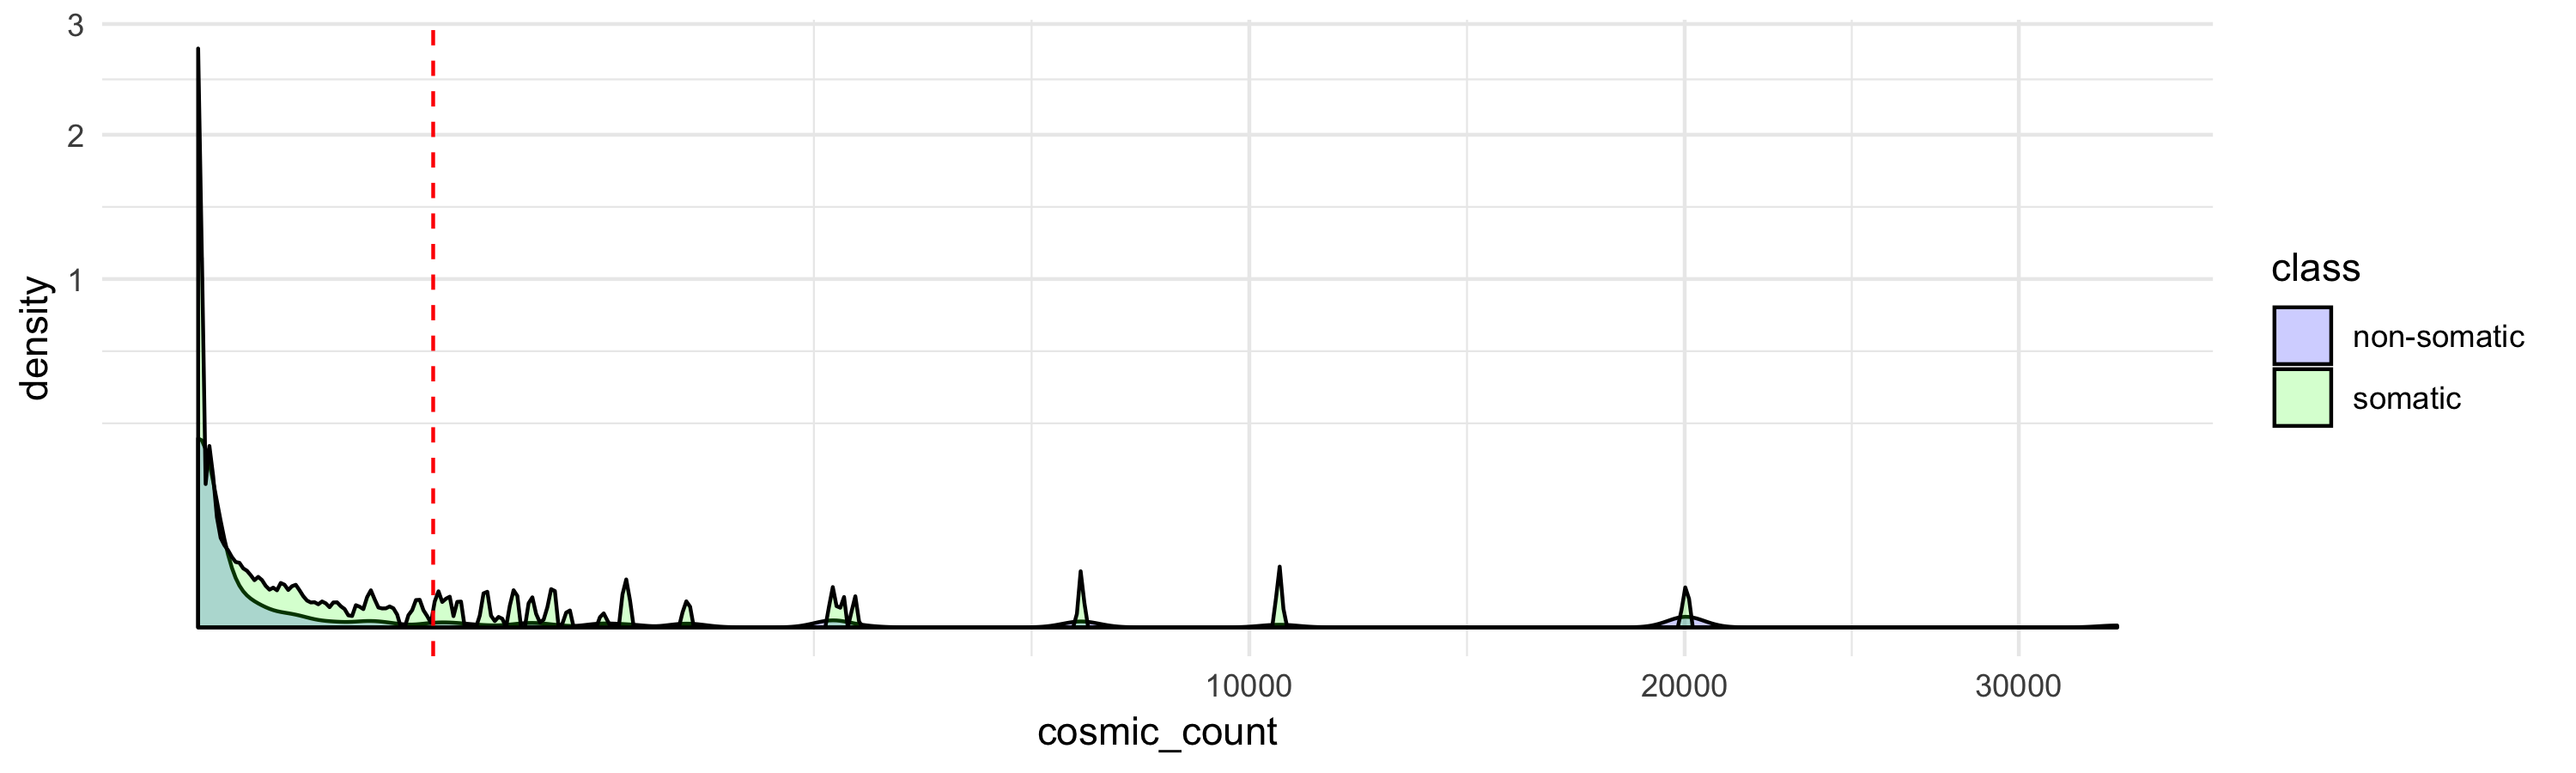

In [89]:
notebook_plot_size(10, 3)
ggplot(impact) + geom_density(aes(cosmic_count, fill = class), alpha = 0.2) +
                 scale_fill_manual(values = c("blue", "green")) + scale_x_sqrt() + scale_y_sqrt() +
                 geom_vline(aes(xintercept = 1000), linetype = "dashed", color = "red")

In [32]:
summary(impact$cosmic_count[impact$class == "somatic"])
summary(impact$cosmic_count[impact$class == "non-somatic"])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0   223.1     1.0 20034.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0     0.0     0.0    77.7     0.0 33328.0 

We observe here that the mutations with a high `cosmic_count` are mostly classified as somatic, even if some have been curated as non_somatic.

In [126]:
unique(impact %>% filter(cosmic_count >= 1000) %>%
        group_by(mut_key) %>%
        mutate(n_somatic = sum(class == "somatic"), n_non_somatic = sum(class == "non-somatic")) %>%
        select(mut_key, Hugo_Symbol, HGVSp_Short, Variant_Type, Consequence, cosmic_count, n_somatic, n_non_somatic) %>%
        arrange(cosmic_count))

mut_key,Hugo_Symbol,HGVSp_Short,Variant_Type,Consequence,cosmic_count,n_somatic,n_non_somatic
1_115256529_T_C,NRAS,p.Q61R,SNP,nonsynonymous_SNV,1003,184,0
12_25398285_C_G,KRAS,p.G12R,SNP,nonsynonymous_SNV,1008,197,5
3_38182641_T_C,MYD88,p.L265P,SNP,nonsynonymous_SNV,1082,27,0
3_178936091_G_A,PIK3CA,p.E545K,SNP,nonsynonymous_SNV,1135,721,1
4_1803568_C_G,FGFR3,p.S249C,SNP,nonsynonymous_SNV,1239,118,0
12_25398285_C_T,KRAS,p.G12S,SNP,nonsynonymous_SNV,1484,79,4
3_178952085_A_G,PIK3CA,p.H1047R,SNP,nonsynonymous_SNV,1651,751,1
12_25398284_C_G,KRAS,p.G12A,SNP,nonsynonymous_SNV,1677,190,1
7_55259515_T_G,EGFR,p.L858R,SNP,nonsynonymous_SNV,2162,305,4
12_25398285_C_A,KRAS,p.G12C,SNP,nonsynonymous_SNV,3645,566,14


## The `key` feature: study of shared mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [93]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "17_7577515_T_G"  "1_46521514_G_C"  "3_142178126_C_A" "4_55139732_T_A" 
[5] "4_153249542_C_A" "4_153332775_C_A"

[1] 135028

### Studying the reccurence of mutations

In [96]:
mut_key_info <- as.data.frame(table(impact$mut_key))
colnames(mut_key_info) <- c("mut_key", "count")
head(mut_key_info)

mut_key,count
1_108206648_AGAAGTTG_GAAGTTGT,1
1_11167549_A_G,1
1_11168271_G_A,1
1_11168272_A_G,1
1_11168304_G_A,1
1_11168316_A_G,1


In [97]:
for (threshold in c(2, 3, 5, 10)) {
    
    n_keys_shared <- nrow(mut_key_info[mut_key_info$count >= threshold,])
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples",
                  100 * n_keys_shared / nrow(mut_key_info),
                  n_keys_shared,
                  threshold))
}

[1] "16% (21843) of the keys are shared by at least  2 samples"
[1] " 5% ( 7320) of the keys are shared by at least  3 samples"
[1] " 2% ( 2394) of the keys are shared by at least  5 samples"
[1] " 1% (  888) of the keys are shared by at least 10 samples"


Distribution of the mutations key count for the keys present in at least 2 samples (warning this is a sqrt x and y scale):

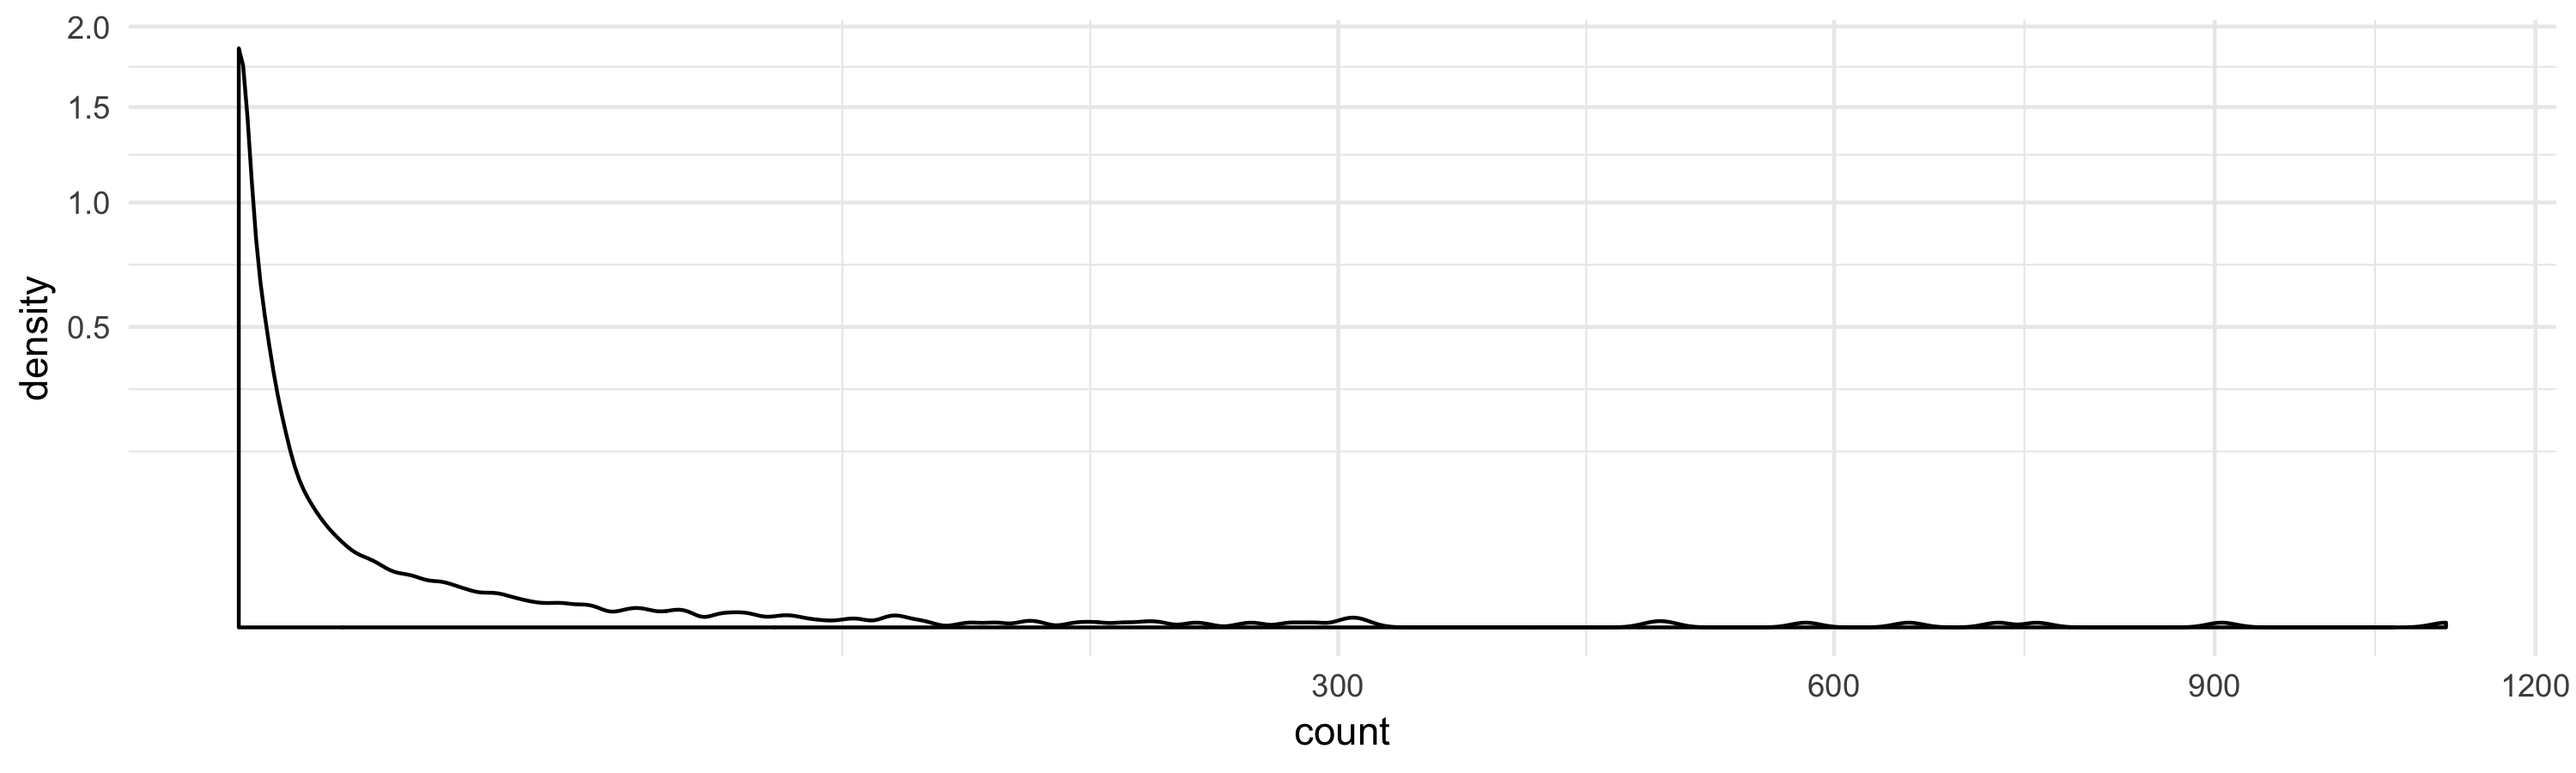

In [99]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
notebook_plot_size(10, 3)
# high adjust to counterpart the non-existing counts which create sharp variations
ggplot(repeated_key) + geom_density(aes(count), adjust = 5) + scale_y_sqrt() + scale_x_sqrt()

### Study of the proportion of inconsistent features

The mutations sharing the same key should have the same following features values: `Hugo_Symbol`, `End_Position`, `Consequence`, `Variant_Type`, `cDNA_change`, `HGVSp_Short`, `confidence_class`, `frequency_in_normals`

We evaluate the number of keys which have 2 or more feature values for a given feature (e.g. the number of keys with inconsistent labels for the given feature):

In [125]:
# We group the mutations with the same key, keeping only the keys that are shared by two or more samples
impact_by_key <- impact[impact$mut_key %in% repeated_key$mut_key,] %>% group_by(mut_key)

for (feature_name in c("Hugo_Symbol", "End_Position", "Variant_Type", "Consequence",
                       "cDNA_change", "HGVSp_Short", "class")) {
    
    # get the number n of unique feature values per key, count the rows where n != 1
    n_inconsistant_labels <- nrow(impact_by_key %>% summarise(n = length(unique(!! sym(feature_name)))) %>%
                                                    filter(n > 1))
    
    print(sprintf("%16s: %.2f%% (%4d) keys with inconsistent labels",
                  feature_name,
                  n_inconsistant_labels / nrow(impact) * 100,
                  n_inconsistant_labels))
}

[1] "     Hugo_Symbol: 0.00% (   0) keys with inconsistent labels"
[1] "    End_Position: 0.00% (   0) keys with inconsistent labels"
[1] "    Variant_Type: 0.00% (   0) keys with inconsistent labels"
[1] "     Consequence: 0.00% (   8) keys with inconsistent labels"
[1] "     cDNA_change: 0.03% (  69) keys with inconsistent labels"
[1] "     HGVSp_Short: 0.14% ( 285) keys with inconsistent labels"
[1] "           class: 0.75% (1478) keys with inconsistent labels"


So every `mut_key` has a unique `Hugo_Symbol`, `End_Position` and `Variant_Type` values, this is consistent. For the other features, the results are quite good as well.

#### Further study

**`Consequence`**

In [118]:
dd <- as.data.frame(impact_by_key %>%
                    summarise(n = length(unique(Consequence)),
                              values = toString(unique(Consequence)),
                              count_per_values = toString(table(Consequence))) %>%
                    filter(n > 1))
dd

mut_key,n,values,count_per_values
12_49444377_A_-,2,"stopgain_SNV, frameshift_deletion","1, 1"
16_3817720_-_T,2,"splicing, frameshift_insertion","6, 2"
16_68849662_-_GT,2,"splicing, frameshift_insertion","1, 2"
19_50919866_G_-,2,"frameshift_deletion, splicing","15, 8"
3_52441465_ATATCCTTTGCTC_T,2,"splicing, nonframeshift_deletion","1, 1"
5_67591145_TACTTGATGT_-,2,"splicing, frameshift_deletion","1, 1"
7_151919086_C_A,2,"splicing, nonsynonymous_SNV","1, 1"
7_55224352_-_GA,2,"splicing, frameshift_insertion","1, 2"


In [119]:
dd <- as.data.frame(impact_by_key %>%
                    summarise(n = length(unique(HGVSp_Short)),
                              values = toString(unique(HGVSp_Short)),
                              count_per_values = toString(table(HGVSp_Short))) %>%
                    filter(n > 1))
head(dd)

mut_key,n,values,count_per_values
1_11190585_C_A,2,", p.X1871_splice","1, 1"
1_115251276_C_A,2,", p.X151_splice","1, 1"
1_175958497_C_T,2,", p.X616_splice","1, 1"
1_243828186_C_T,2,", p.X58_splice","1, 1"
1_27102199_G_A,2,", p.X1708_splice","1, 1"
1_27106696_T_-,2,"p.S2104fs, p.S2104Pfs*31","1, 1"
1_45795028_G_A,2,"p.R520W, p.R534W","1, 1"
1_45795032_G_T,2,"p.F518L, p.F532L","1, 1"
1_45795084_G_A,2,"p.S501F, p.S515F","8, 3"
1_45796865_C_A,2,"p.A475S, p.A489S","1, 1"


In [28]:
table(dd$Hugo_Symbol)


   APC     AR ARID1A   ATRX   BAP1  BRCA1 CDKN2A CREBBP   EGFR  FOXA1 INPP4B 
     1      2      1      1      1      2      2      1      2      1      1 
   KIT  KMT2A  KMT2B  KMT2C  KMT2D  MUTYH  PBRM1 PIK3R1  PTCH1   PTEN  RBM10 
     1      2      1      6      6     15      1      2      2      3      1 
  TP53 
    19 

In [122]:
dd <- as.data.frame(impact_by_key %>%
                    summarise(n = length(unique(class)),
                              values = toString(unique(class)),
                              count_per_values = toString(table(class))) %>%
                    filter(n > 1))
head(dd)

mut_key,n,values,count_per_values
1_11259339_G_A,2,"somatic, non-somatic","1, 1"
1_11291110_G_A,2,"non-somatic, somatic","1, 1"
1_11303193_G_A,2,"non-somatic, somatic","1, 1"
1_115256528_T_A,2,"somatic, non-somatic","2, 12"
1_115256529_T_A,2,"somatic, non-somatic","1, 58"
1_115256530_G_T,2,"somatic, non-somatic","1, 126"


### Sudy of the reccurent mutations

In [101]:
impact_rec <- impact[impact$mut_key %in% repeated_key$mut_key,]
length(unique(impact_rec$Hugo_Symbol))

[1] 468

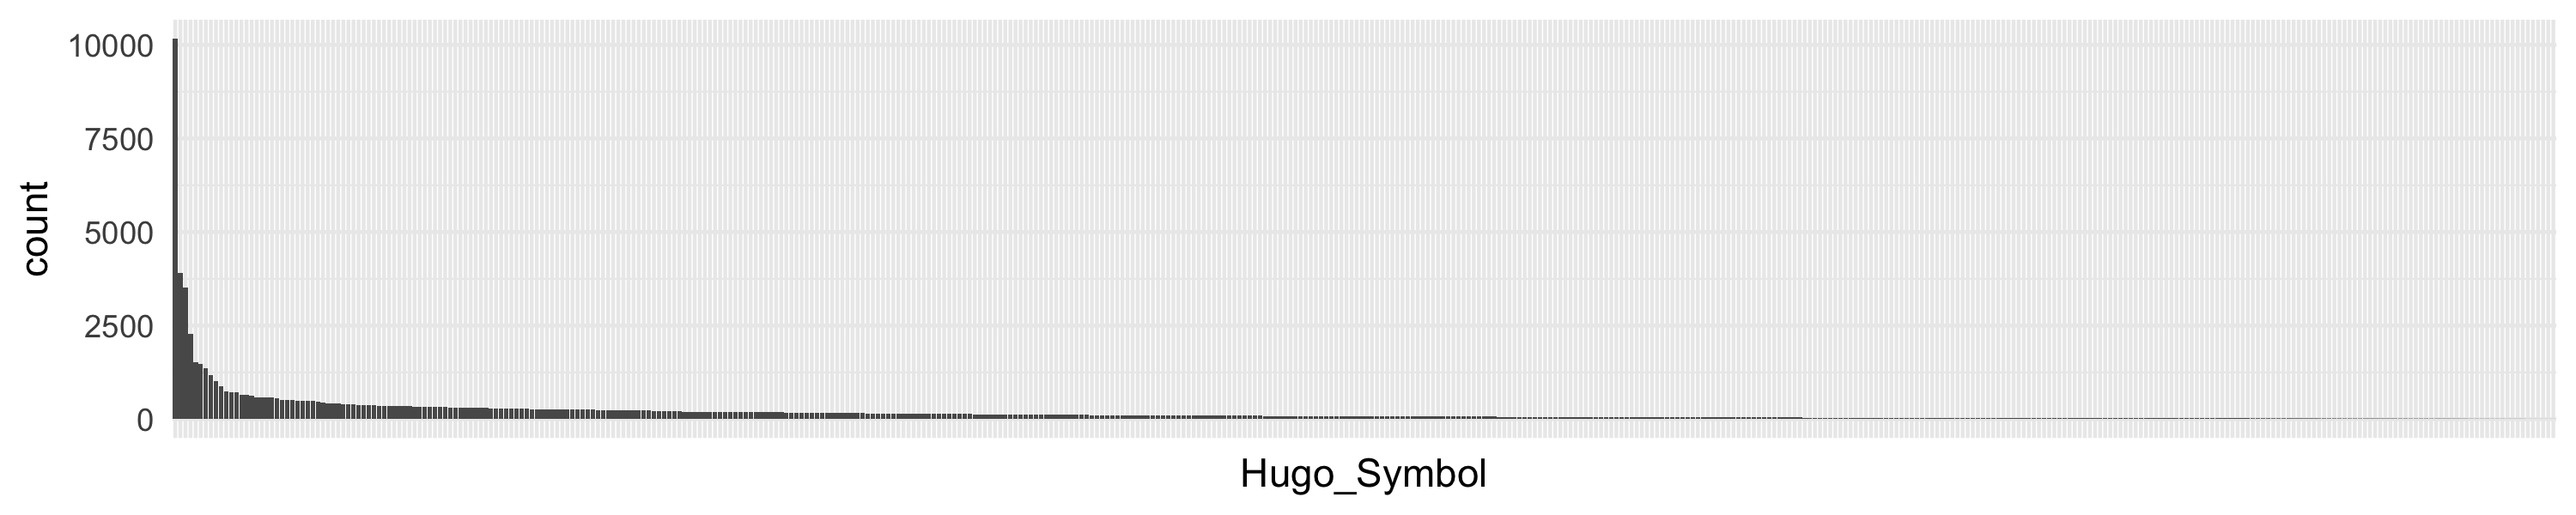

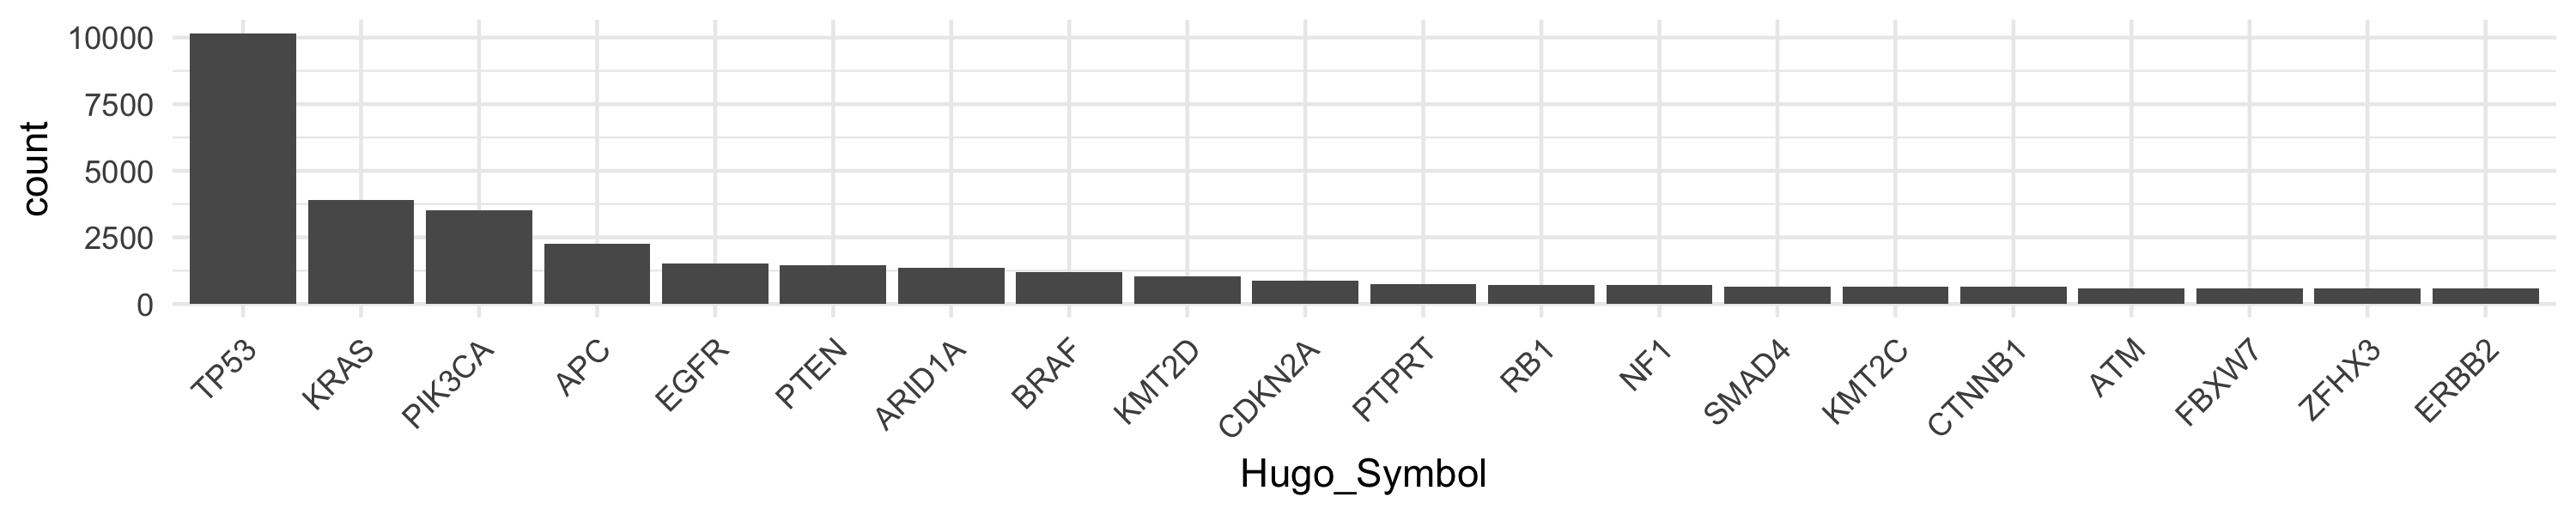

In [102]:
impact_rec <- sort_histogram(impact_rec, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(impact_rec) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(impact_rec, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))